In [29]:
"""
3D forward modeling of total-field magnetic anomaly using triaxial
ellipsoids (model with isotropic and anisotropic susceptibilities)
"""
# insert the figures in the notebook
%matplotlib inline

import numpy as np
from fatiando import utils, gridder
import triaxial_ellipsoid
from mesher import TriaxialEllipsoid
import plot_functions as pf
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

### Parallel geomagnetic field

In [38]:
# Create a regular grid at 0m height
shape = (200, 200)
area = [-5000, 5000, -5000, 5000]
xp, yp, zp = gridder.regular(area, shape, z = 0)

# The regional field
F, inc, dec = 23500., 0, 0

# Create a model formed by two ellipsoids
# The first ellipsoid does not have remanent magnetization and
# has an anisotropic susceptibility (different principal susceptibilities
# k1 = 0.3, k2 = 0.3, k3 = 0.1). 
# The second has a remanent magnetization of 2 A/m
# and an isotropic susceptibility of (all principal susceptibilities
# equal to 0.01)

lamb = np.array([1000., 500., 0.])
model1 = []
tf_p =[]

for i in lamb:
    model1 = [TriaxialEllipsoid(0., 0., 2000., 900.+i, 600.+i, 300.+i, 0., 0., 0.,
                               {'principal susceptibilities': [0.1, 0.1, 0.1],
                              'susceptibility angles': [-20., 20., 9.]})]
    
    # Calculate the total-field anomaly
    tf_p.append(triaxial_ellipsoid.tf(xp, yp, zp, model1, F, inc, dec))



















### Oblique geomagnetic field

In [43]:
# The regional field
F, inc, dec = 23500., 20, 30

# Create a model formed by two ellipsoids
# The first ellipsoid does not have remanent magnetization and
# has an anisotropic susceptibility (different principal susceptibilities
# k1 = 0.3, k2 = 0.3, k3 = 0.1). 
# The second has a remanent magnetization of 2 A/m
# and an isotropic susceptibility of (all principal susceptibilities
# equal to 0.01)

model2 = []
tf_o =[]

for i in lamb:
    model2 = [TriaxialEllipsoid(0., 0., 2000., 900.+i, 600.+i, 300.+i, 0., 0., 0.,
                               {'principal susceptibilities': [0.1, 0.1, 0.1],
                              'susceptibility angles': [-20., 20., 9.]})]
    
    # Calculate the total-field anomaly
    tf_o.append(triaxial_ellipsoid.tf(xp, yp, zp, model2, F, inc, dec))

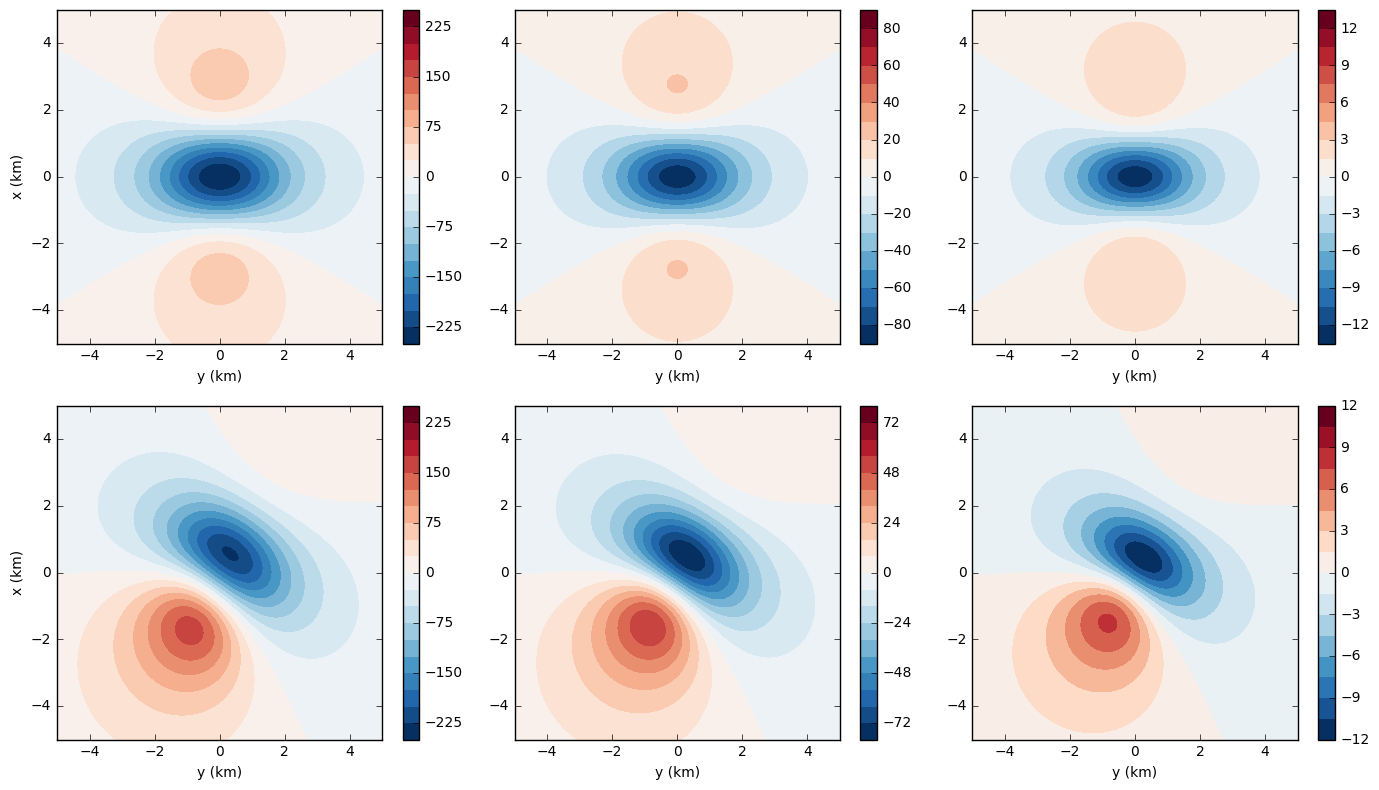

In [63]:
# Plot the results
plt.close('all')
plt.figure(figsize=(14,8))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_p[0]), np.max(tf_p[0])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(2,3,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_p[0].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()


ranges = np.max(np.abs([np.min(tf_p[1]), np.max(tf_p[1])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(2,3,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_p[1].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

ranges = np.max(np.abs([np.min(tf_p[2]), np.max(tf_p[2])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(2,3,3)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_p[2].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

ranges = np.max(np.abs([np.min(tf_o[0]), np.max(tf_o[0])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(2,3,4)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_o[0].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

ranges = np.max(np.abs([np.min(tf_o[1]), np.max(tf_o[1])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(2,3,5)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_o[1].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

ranges = np.max(np.abs([np.min(tf_o[2]), np.max(tf_o[2])]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(2,3,6)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_o[2].reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

plt.tight_layout()

plt.show()

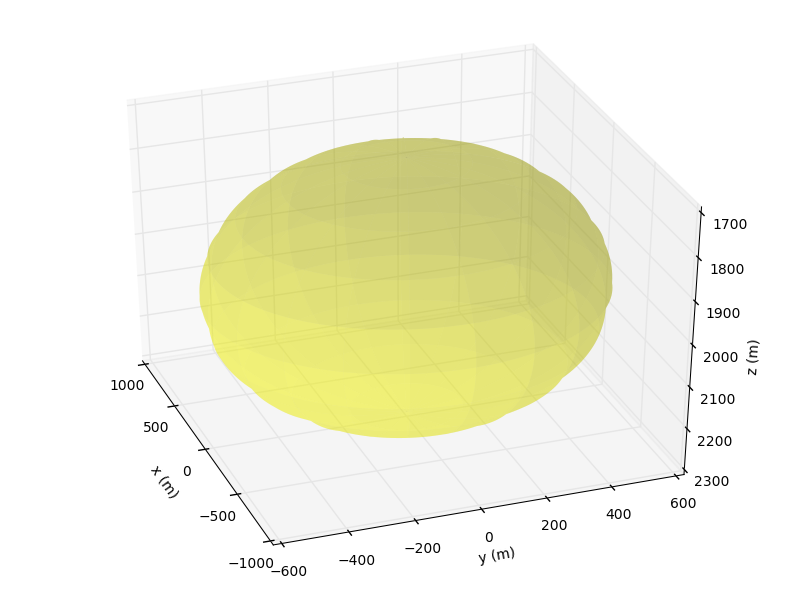

In [24]:
plt.close('all')
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

for m in model1:
    pf.draw_ellipsoid(ax, m, body_color=(1,1,0), body_alpha=0.3)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

ax.view_init(215, 20)

plt.tight_layout(True)

plt.show()